#  Predicting Car Prices with Linear Regression

This notebook builds a car price prediction model using the **MSRP** (Manufacturer Suggested Retail Price) dataset. The workflow includes:

* Data preprocessing
* Exploratory Data Analysis (EDA)
* Feature engineering
* Model training with linear regression
* Regularization and model evaluation

---

##  Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df.shape

(11914, 16)

##  Initial Exploration

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


We examine the structure and data types:


In [4]:
df.dtypes

Make                  object
Model                 object
Year                   int64
Engine Fuel Type      object
Engine HP            float64
Engine Cylinders     float64
Transmission Type     object
Driven_Wheels         object
Number of Doors      float64
Market Category       object
Vehicle Size          object
Vehicle Style         object
highway MPG            int64
city mpg               int64
Popularity             int64
MSRP                   int64
dtype: object

##  Data Cleaning and Normalization

### Normalize column names:

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')


## Separate string and numerical columns:

In [6]:
string_columns = df.select_dtypes(include='object').columns.tolist()
num_columns = df.select_dtypes(exclude='object').columns.tolist()

In [7]:
string_columns

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [8]:
num_columns

['year',
 'engine_hp',
 'engine_cylinders',
 'number_of_doors',
 'highway_mpg',
 'city_mpg',
 'popularity',
 'msrp']

# **Normalize string values:**

In [9]:
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

##  Exploratory Data Analysis (EDA)

### Target variable: `msrp`

We examine unique values and distributions in features like `make`, `model`, `fuel_type`, etc.

In [10]:
for col in string_columns:
    print(col)
    print(df[col].unique()[:5])
    print(len(df[col].unique()))
    print()

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler']
48

model
['1_series_m' '1_series' '100' '124_spider' '190-class']
914

engine_fuel_type
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel']
11

transmission_type
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']
5

driven_wheels
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']
4

market_category
['factory_tuner,luxury,high-performance' 'luxury,performance'
 'luxury,high-performance' 'luxury' 'performance']
72

vehicle_size
['compact' 'midsize' 'large']
3

vehicle_style
['coupe' 'convertible' 'sedan' 'wagon' '4dr_hatchback']
16



* View sample unique values and the count of unique categories per categorical column.




### Target Variable Distribution (MSRP)

We visualize the MSRP distribution using histograms and apply a log transformation to reduce skew.


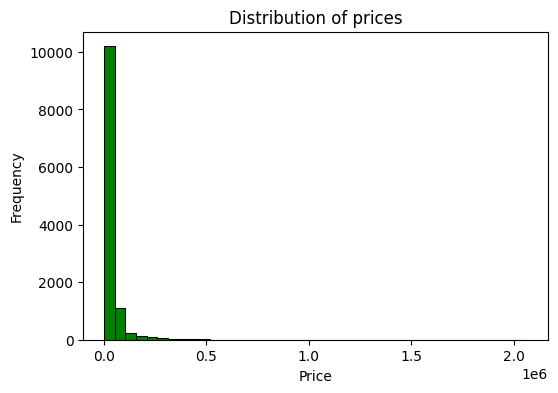

In [11]:
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp, bins=40, color='green', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

> Visualize the price distribution using a histogram. The data is skewed due to high-priced outliers.


### Focus on Prices Below \$100K

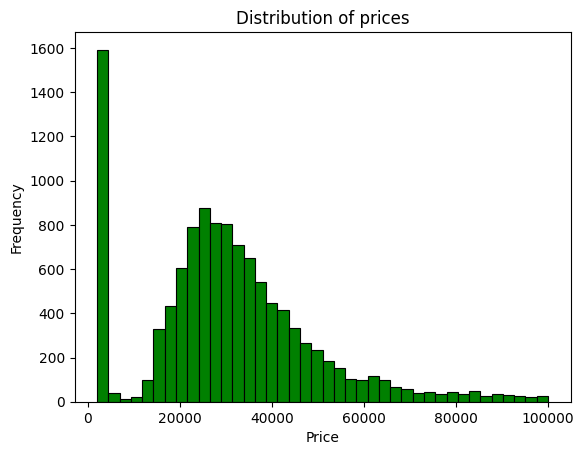

In [12]:

sns.histplot(df.msrp[df.msrp < 100000], bins=40, color='green', alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

>Visualize the price distribution for more typical price ranges.

### Log Transformation


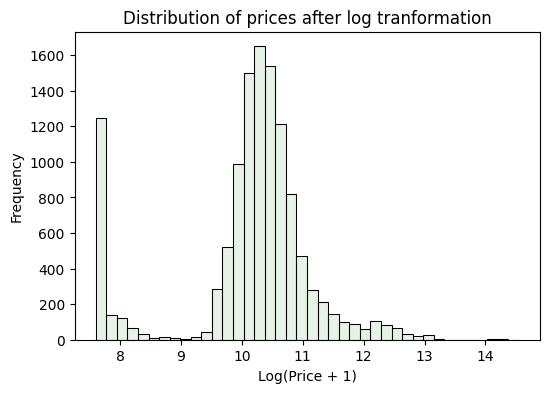

In [13]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, color='green', alpha=0.1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

>Apply `log1p` transformation to reduce skew and normalize distribution.


##  Missing Value Analysis

We identify missing values in numeric and categorical columns to inform imputation strategies.


In [14]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

>Summarize missing values across all columns. This will help decide whether to drop or impute missing data.


## 🧪 Train/Validation/Test Split

We randomly shuffle the dataset and split it:

* 60% training
* 20% validation
* 20% test

Log-transformed MSRP is used as the target variable.



In [15]:
np.random.seed(2)
n = len(df)
n

11914

In [16]:
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
n , n_train+n_test+n_val

(11914, 11914)

In [17]:
idx = np.arange(n)
idx

array([    0,     1,     2, ..., 11911, 11912, 11913], shape=(11914,))

In [18]:
np.random.shuffle(idx)
idx

array([2735, 6720, 5878, ..., 6637, 2575, 7336], shape=(11914,))

In [19]:
df_shuffled = df.iloc[idx]
df_shuffled

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
2735,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,14410
6720,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,19685
5878,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640,19795
11190,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873,2000
4554,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657,56260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2514,chevrolet,chevy_van,1998,regular_unleaded,200.0,6.0,automatic,rear_wheel_drive,3.0,NaN,midsize,cargo_van,18,13,1385,2052
11798,subaru,xv_crosstrek,2014,regular_unleaded,160.0,4.0,automatic,all_wheel_drive,4.0,"crossover,hybrid",compact,4dr_suv,33,29,640,25995
6637,dodge,magnum,2006,regular_unleaded,250.0,6.0,automatic,all_wheel_drive,4.0,NaN,large,wagon,22,15,1851,29100
2575,honda,civic,2016,regular_unleaded,174.0,4.0,automatic,front_wheel_drive,4.0,NaN,midsize,sedan,42,31,2202,22200


In [20]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()
df_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
2735,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,14410
6720,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,19685
5878,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640,19795
11190,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873,2000
4554,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657,56260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,bmw,4_series,2015,premium_unleaded_(required),300.0,6.0,automatic,rear_wheel_drive,2.0,"luxury,performance",midsize,convertible,31,20,3916,54900
1902,volkswagen,beetle,2015,premium_unleaded_(recommended),210.0,4.0,automated_manual,front_wheel_drive,2.0,"hatchback,performance",compact,2dr_hatchback,30,24,873,29215
9334,gmc,sierra_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,four_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,22,17,549,34675
5284,rolls-royce,ghost,2014,premium_unleaded_(required),563.0,12.0,automatic,rear_wheel_drive,4.0,"exotic,luxury,performance",large,sedan,21,13,86,303300


>`copy()` is used to avoid SettingWithCopy warnings when manipulating subsets later.

### Prepare Target Variables

In [21]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values
y_train_orig

array([ 14410,  19685,  19795, ...,  34675, 303300,  37820], shape=(7150,))

In [22]:
y_train = np.log1p(y_train_orig )
y_val = np.log1p(y_val_orig)
y_test = np.log1p(y_test_orig)
y_train

array([ 9.57574708,  9.887663  ,  9.89323518, ..., 10.45380308,
       12.62248099, 10.54061978], shape=(7150,))

In [23]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

In [24]:
df_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
2735,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385
6720,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031
5878,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640
11190,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873
4554,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,bmw,4_series,2015,premium_unleaded_(required),300.0,6.0,automatic,rear_wheel_drive,2.0,"luxury,performance",midsize,convertible,31,20,3916
1902,volkswagen,beetle,2015,premium_unleaded_(recommended),210.0,4.0,automated_manual,front_wheel_drive,2.0,"hatchback,performance",compact,2dr_hatchback,30,24,873
9334,gmc,sierra_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,four_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,22,17,549
5284,rolls-royce,ghost,2014,premium_unleaded_(required),563.0,12.0,automatic,rear_wheel_drive,4.0,"exotic,luxury,performance",large,sedan,21,13,86


>Save both the original MSRP values and log-transformed targets for training and evaluation.
---
> Remove the target column (`msrp`) from the feature sets.


In [25]:
df_train.iloc[10]

make                                 rolls-royce
model                     phantom_drophead_coupe
year                                        2015
engine_fuel_type     premium_unleaded_(required)
engine_hp                                  453.0
engine_cylinders                            12.0
transmission_type                      automatic
driven_wheels                   rear_wheel_drive
number_of_doors                              2.0
market_category        exotic,luxury,performance
vehicle_size                               large
vehicle_style                        convertible
highway_mpg                                   19
city_mpg                                      11
popularity                                    86
Name: 7557, dtype: object


##  Linear Regression — Closed-form Solution

We aim to find the weights $w$ that best fit the linear model:

$$
g(X) = X \cdot w = y
$$

To solve for $w$, we use the **Normal Equation**:

$$
X^T X w = X^T y
$$

Assuming $X^T X$ is invertible, we multiply both sides by $(X^T X)^{-1}$:

$$
w = (X^T X)^{-1} X^T y
$$

This is the **closed-form solution** to linear regression.




##  Summary

The correct and compact formula for computing the optimal weights $w$ in linear regression is:

$$
\boxed{w = (X^T X)^{-1} X^T y}
$$

This formula assumes that the features matrix $X$ includes a bias column (usually all ones), and that $X^T X$ is invertible.



In [26]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

>This function implements the closed-form solution of linear regression using the **normal equation**:
$$
w = (X^T X)^{-1} X^T y
$$
It returns the bias term (`w₀`) and the weights (`w`).


##  Baseline Model

We begin with a basic set of numerical features:

* `engine_hp`, `engine_cylinders`, `highway_mpg`, `city_mpg`, `popularity`

Missing values are filled with zero. We evaluate model performance using RMSE.

In [27]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_train[base]

,engine_hp,engine_cylinders,highway_mpg,city_mpg,popularity
2735,148.0,4.0,33,24,1385
6720,132.0,4.0,32,25,2031
5878,148.0,4.0,37,28,640
11190,90.0,4.0,18,16,873
4554,385.0,8.0,21,15,5657
...,...,...,...,...,...
434,300.0,6.0,31,20,3916
1902,210.0,4.0,30,24,873
9334,285.0,6.0,22,17,549
5284,563.0,12.0,21,13,86


In [28]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

>* Fill missing values with zero and convert selected columns to a NumPy array.


##  Predictions and Evaluation

In [29]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

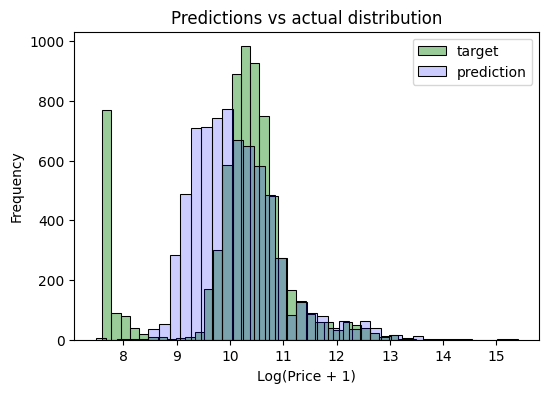

In [30]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, label='target', color='green', alpha=0.4, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.2, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

# Root Mean Squared Error (RMSE)
---


###  RMSE Definition:

$$
\text{RMSE} = \sqrt{ \frac{1}{m} \sum_{i=1}^{m} \left( g(x_i) - y_i \right)^2 }
$$

---

###  Explanation:

* **$m$**: Number of data points.
* **$g(x_i)$**: The **model’s prediction** for the input $x_i$.
* **$y_i$**: The **actual (true)** value.
* **$g(x_i) - y_i$**: The error for the i-th prediction.
* **$\left( g(x_i) - y_i \right)^2$**: Squared error for the i-th data point.
* **$\sum_{i=1}^{m}$**: Sum over all training examples.
* **$\frac{1}{m}$**: Mean of the squared errors.
* **$\sqrt{}$**: Taking the square root to bring the error back to original units.

---

###  Summary :

> **RMSE measures the average magnitude of the prediction errors — it penalizes large errors more than small ones due to the squaring.**



In [31]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

We use **Root Mean Squared Error (RMSE)** to evaluate model performance.


In [32]:
rmse(y_train, y_pred)

np.float64(0.7554192603920132)

##  Validation

In [33]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
rmse(y_val, y_pred)

np.float64(0.761653099130156)

>Initial validation shows some room for improvement.


##  Feature Engineering

We add:

* **Age** of the car: `2017 - year`
* One-hot encodings for:

  * Door counts (2, 3, 4)
  * Car make (top 45 brands)
  * Fuel type (top 6)
  * Transmission type
  * Market category (top 15)
  * Vehicle style (top 13)

Each is encoded as binary features (`is_*`).

## 1-  feature engineering (Adding Age)

In [34]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [35]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred))

train 0.5175055465840046
validation 0.5172055461058299


>We observed an improvement in the Root Mean Square Error (RMSE).

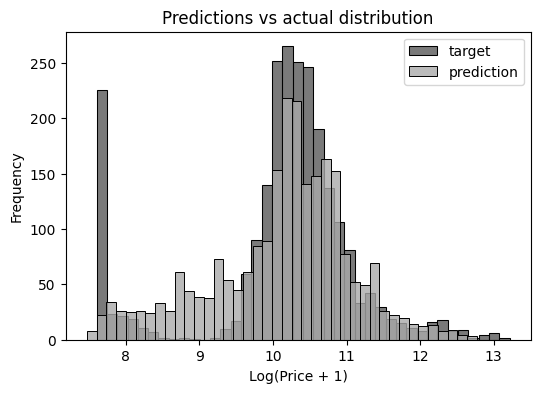

In [36]:
plt.figure(figsize=(6, 4))


sns.histplot(y_val, label='target', color='#222222', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='#aaaaaa', alpha=0.8, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

# Categorical Variables 

In [37]:
df['make'].value_counts()

make
chevrolet        1123
ford              881
volkswagen        809
toyota            746
dodge             626
nissan            558
gmc               515
honda             449
mazda             423
cadillac          397
mercedes-benz     353
suzuki            351
bmw               334
infiniti          330
audi              328
hyundai           303
volvo             281
subaru            256
acura             252
kia               231
mitsubishi        213
lexus             202
buick             196
chrysler          187
pontiac           186
lincoln           164
oldsmobile        150
land_rover        143
porsche           136
saab              111
aston_martin       93
plymouth           82
bentley            74
ferrari            69
fiat               62
scion              60
maserati           58
lamborghini        52
rolls-royce        31
lotus              29
tesla              18
hummer             17
maybach            16
alfa_romeo          5
mclaren             5
spyke

## 2-  feature engineering Car make (top 42 brands))

In [38]:
make = list(df['make'].value_counts().index)[:-6]
make

['chevrolet',
 'ford',
 'volkswagen',
 'toyota',
 'dodge',
 'nissan',
 'gmc',
 'honda',
 'mazda',
 'cadillac',
 'mercedes-benz',
 'suzuki',
 'bmw',
 'infiniti',
 'audi',
 'hyundai',
 'volvo',
 'subaru',
 'acura',
 'kia',
 'mitsubishi',
 'lexus',
 'buick',
 'chrysler',
 'pontiac',
 'lincoln',
 'oldsmobile',
 'land_rover',
 'porsche',
 'saab',
 'aston_martin',
 'plymouth',
 'bentley',
 'ferrari',
 'fiat',
 'scion',
 'maserati',
 'lamborghini',
 'rolls-royce',
 'lotus',
 'tesla',
 'hummer']

In [39]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [40]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 0.4519674160571752
validation: 0.45710602331400224


>We observed an improvement in the Root Mean Square Error (RMSE).

## 3-  feature engineering Door counts (2, 3, 4))

In [41]:
number_of_doors = list(df['number_of_doors'].value_counts().index)
number_of_doors

[4.0, 2.0, 3.0]

In [42]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')

    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)
#['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']
    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [43]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 0.45093766471450475
validation: 0.4563602430564519


## 4-  feature engineering Fuel type (top 6))

In [44]:
df['engine_fuel_type'].value_counts()

engine_fuel_type
regular_unleaded                                7172
premium_unleaded_(required)                     2009
premium_unleaded_(recommended)                  1523
flex-fuel_(unleaded/e85)                         899
diesel                                           154
electric                                          66
flex-fuel_(premium_unleaded_required/e85)         54
flex-fuel_(premium_unleaded_recommended/e85)      26
flex-fuel_(unleaded/natural_gas)                   6
natural_gas                                        2
Name: count, dtype: int64

In [45]:
engine_fuel_type =list(df['engine_fuel_type'].value_counts().index)[:-4]
engine_fuel_type



['regular_unleaded',
 'premium_unleaded_(required)',
 'premium_unleaded_(recommended)',
 'flex-fuel_(unleaded/e85)',
 'diesel',
 'electric']

In [46]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in engine_fuel_type:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [47]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 0.4357622804871244
validation: 0.43668245218554314


>We observed an improvement in the Root Mean Square Error (RMSE).

## **5 -feature engineering Transmission type**

In [48]:
df['transmission_type'].value_counts()

transmission_type
automatic           8266
manual              2935
automated_manual     626
direct_drive          68
unknown               19
Name: count, dtype: int64

In [49]:
transmission_type = list(df['transmission_type'].value_counts().index)[:-1]
transmission_type

['automatic', 'manual', 'automated_manual', 'direct_drive']

In [50]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in engine_fuel_type:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    for v in transmission_type:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [51]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 0.42980697627107456
validation: 0.43075397764121576


## **6 -feature engineering driven wheels**

In [52]:
df['driven_wheels'].value_counts()

driven_wheels
front_wheel_drive    4787
rear_wheel_drive     3371
all_wheel_drive      2353
four_wheel_drive     1403
Name: count, dtype: int64

In [53]:

driven_wheels = list(df['driven_wheels'].value_counts().index)
driven_wheels

['front_wheel_drive',
 'rear_wheel_drive',
 'all_wheel_drive',
 'four_wheel_drive']

In [54]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in engine_fuel_type:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    for v in transmission_type:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in driven_wheels:
        feature = 'is_driven_wheels_%s' % v
        df[feature] = (df['driven_wheels'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [55]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 71.53092654240929
validation: 26.345873066395573


>very bad I want to remove this feature  driven_wheels

## **7 -feature engineering market category**

In [56]:
df['market_category'].value_counts().head(15)


market_category
crossover                                1110
flex_fuel                                 872
luxury                                    855
luxury,performance                        673
hatchback                                 641
performance                               601
crossover,luxury                          410
luxury,high-performance                   334
exotic,high-performance                   261
hatchback,performance                     252
factory_tuner,luxury,high-performance     215
high-performance                          199
hybrid                                    123
crossover,luxury,performance              113
factory_tuner,high-performance            106
Name: count, dtype: int64

In [57]:
market_category = list(df['market_category'].value_counts().head(15).index)
market_category

['crossover',
 'flex_fuel',
 'luxury',
 'luxury,performance',
 'hatchback',
 'performance',
 'crossover,luxury',
 'luxury,high-performance',
 'exotic,high-performance',
 'hatchback,performance',
 'factory_tuner,luxury,high-performance',
 'high-performance',
 'hybrid',
 'crossover,luxury,performance',
 'factory_tuner,high-performance']

In [58]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in engine_fuel_type:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    for v in transmission_type:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in market_category:
        feature = 'is_market_category_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [59]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 0.42628190769083013
validation: 0.42892805591885363


## **8 -feature engineering vehicle size**

In [60]:
df['vehicle_size'].value_counts()

vehicle_size
compact    4764
midsize    4373
large      2777
Name: count, dtype: int64

In [61]:
vehicle_size = list(df['vehicle_size'].value_counts().index)
vehicle_size

['compact', 'midsize', 'large']

In [62]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in engine_fuel_type:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    for v in transmission_type:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in market_category:
        feature = 'is_market_category_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in vehicle_size:
        feature = 'is_vehicle_size_%s' % v
        df[feature] = (df['vehicle_size'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [63]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 104.67375700006862
validation: 39.95071725492393


>very bad I want to remove this feature  vehicle_size

## **9 -feature engineering vehicle style**

In [64]:
df['vehicle_style'].value_counts()

vehicle_style
sedan                  3048
4dr_suv                2488
coupe                  1211
convertible             793
4dr_hatchback           702
crew_cab_pickup         681
extended_cab_pickup     623
wagon                   592
2dr_hatchback           506
passenger_minivan       417
regular_cab_pickup      392
2dr_suv                 138
passenger_van           128
cargo_van                95
cargo_minivan            71
convertible_suv          29
Name: count, dtype: int64

In [65]:
vehicle_style = list(df['vehicle_style'].value_counts().head(13).index)
vehicle_style

['sedan',
 '4dr_suv',
 'coupe',
 'convertible',
 '4dr_hatchback',
 'crew_cab_pickup',
 'extended_cab_pickup',
 'wagon',
 '2dr_hatchback',
 'passenger_minivan',
 'regular_cab_pickup',
 '2dr_suv',
 'passenger_van']

In [66]:
def prepare_X(df):
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    for v in make:
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)

    for v in engine_fuel_type:
        feature = 'is_type_%s' % v
        df[feature] = (df['engine_fuel_type'] == v).astype(int)
        features.append(feature)
        
    for v in transmission_type:
        feature = 'is_transmission_%s' % v
        df[feature] = (df['transmission_type'] == v).astype(int)
        features.append(feature)

    for v in market_category:
        feature = 'is_market_category_%s' % v
        df[feature] = (df['market_category'] == v).astype(int)
        features.append(feature)

    for v in vehicle_style:
        feature = 'is_vehicle_style_%s' % v
        df[feature] = (df['vehicle_style'] == v).astype(int)
        features.append(feature)
        
    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X , features

In [67]:
X_train ,features= prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

y_pred = w_0 + X_train.dot(w)
print('train:', rmse(y_train, y_pred))

X_val ,features = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))



train: 0.41550325654546005
validation: 0.4203705853150421


##  Numerical Instability Issue

At some point, predictions became unreasonable due to matrix inversion instability.



## Regularization — Ridge Regression (L2)

When \( X^T X \) is **non-invertible** or **ill-conditioned** (e.g., features are correlated or too many), we use **regularization** to stabilize the solution.

One common approach is **Ridge Regression**, which introduces a regularization term \( \\lambda \| w \|^2 \):

$$
w = (X^T X + \lambda I)^{-1} X^T y
$$

Where:

- \( \lambda > 0 \) is the regularization parameter.
- \( I \) is the identity matrix (same size as \( X^T X \)).

This discourages large weights and reduces overfitting, especially when dealing with multicollinearity or small datasets.

---

##  Summary

- **Linear Regression :**

  $$
  \boxed{w = (X^T X)^{-1} X^T y}
  $$

- **Ridge Regression (Regularized):**

  $$
  \boxed{w = (X^T X + \lambda I)^{-1} X^T y}
  $$

> Make sure the feature matrix \( X \) includes a bias term (e.g., a column of ones), and remember to tune \( \lambda \) based on validation data.


In [68]:
X = np.array([
    [3,2 , 2],
    [ 3 , 2 ,2],
    [5 ,2 , 2]])

In [69]:
XTX = X.T.dot(X)
XTX

array([[43, 22, 22],
       [22, 12, 12],
       [22, 12, 12]])

In [70]:
XTX_inv = np.linalg.inv(XTX)
XTX_inv

LinAlgError: Singular matrix

This is Singular matrix to solve this we add small numbers to matrix

In [71]:
X = np.array([
    [3,2 , 2],
    [ 3 , 2 ,2],
    [5 ,2 , 2.54]])
XTX = X.T.dot(X)
XTX_inv = np.linalg.inv(XTX)
XTX_inv

array([[ 4.10390516e+13,  9.04379100e+13, -1.51996487e+14],
       [ 9.04379100e+13,  1.99298357e+14, -3.34955222e+14],
       [-1.51996487e+14, -3.34955222e+14,  5.62949953e+14]])

In [72]:
X = np.array([
    [3,2 , 2],
    [ 3 , 2 ,2],
    [5 ,2 , 2]])
XTX = X.T.dot(X)
reg = 0.05 * np.eye(XTX.shape[0])
XTX =XTX + reg
XTX_inv = np.linalg.inv(XTX)
XTX_inv

array([[ 0.35707657, -0.32663969, -0.32663969],
       [-0.32663969, 10.31958725, -9.68041275],
       [-0.32663969, -9.68041275, 10.31958725]])

In [73]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

>To stabilize the solution, apply **L2 regularization** (Ridge):


In [74]:
X_train , _ = prepare_X(df_train)


In [75]:
for r in [0, 0.001, 0.01, 0.1, 1, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    print('%5s, %.2f, %.2f, %.2f' % (r, w_0, w[13], w[21]))

    0, 10.76, -3.84, -6.58
0.001, 10.77, -3.58, -6.01
 0.01, 10.77, -2.31, -3.27
  0.1, 10.35, -0.84, -0.25
    1, 8.16, -0.36, -0.02
   10, 5.40, -0.15, -0.22


In [86]:
X_train, _ = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val ,_= prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 0.41550325654546005
val 0.4203705853150421


In [87]:
X_train, _ = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=.01)

y_pred = w_0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val ,_= prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('val', rmse(y_val, y_pred))

train 0.4156464031986307
val 0.42027265268016045


In [88]:
X_train ,_ = prepare_X(df_train)
X_val ,_= prepare_X(df_val)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w_0, w = train_linear_regression_reg(X_train, y_train, r=r)
    y_pred = w_0 + X_val.dot(w)
    print('|','%6s' %r, " | ",rmse(y_val, y_pred),"|\n")

|  1e-06  |  0.42037056717270366 |

| 0.0001  |  0.4203687856893119 |

|  0.001  |  0.42035397742076225 |

|   0.01  |  0.42027265268016045 |

|    0.1  |  0.42013990400426166 |

|      1  |  0.42256915967262315 |

|      5  |  0.43255327773756247 |

|     10  |  0.44456514877460246 |



Tested multiple regularization strengths. A small value like `r=0.1` gave the best RMSE.


In [89]:
X_train ,_ = prepare_X(df_train)
w_0, w = train_linear_regression_reg(X_train, y_train, r=0.1)

X_val ,_ = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)
print('validation:', rmse(y_val, y_pred))

X_test ,_ = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))

validation: 0.42013990400426166
test: 0.4130151180438185


## Using the model

In [90]:
df_full_train = pd.concat([df_train , df_val])
df_full_train = df_full_train.reset_index(drop=True)
df_full_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity
0,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385
1,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031
2,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640
3,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873
4,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9527,volvo,v60,2015,regular_unleaded,240.0,4.0,automatic,front_wheel_drive,4.0,luxury,midsize,wagon,37,25,870
9528,maserati,granturismo_convertible,2015,premium_unleaded_(required),444.0,8.0,automatic,rear_wheel_drive,2.0,"exotic,luxury,high-performance",midsize,convertible,20,13,238
9529,cadillac,escalade_hybrid,2013,regular_unleaded,332.0,8.0,automatic,rear_wheel_drive,4.0,"luxury,hybrid",large,4dr_suv,23,20,1624
9530,mitsubishi,lancer,2016,regular_unleaded,148.0,4.0,manual,front_wheel_drive,4.0,NaN,compact,sedan,34,24,436


In [91]:
n ,n_train+n_test, n_train,n_test,n_val

(11914, 9532, 7150, 2382, 2382)

In [92]:
X_full_train ,_ =prepare_X(df_full_train)
y_full_train = np.concatenate([y_train , y_val])
w_0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.1)

#----

X_test ,_ = prepare_X(df_test)
y_pred = w_0 + X_test.dot(w)
print('test:', rmse(y_test, y_pred))


test: 0.41270097804178807


In [93]:
y_full_train = np.concatenate([y_train , y_val])
y_full_train

array([ 9.57574708,  9.887663  ,  9.89323518, ..., 11.21756062,
        9.77542688, 10.1924563 ], shape=(9532,))

In [94]:
i = 11
ad = df_test.iloc[i].to_dict()
ad

{'make': 'volkswagen',
 'model': 'golf_gti',
 'year': 2015,
 'engine_fuel_type': 'premium_unleaded_(recommended)',
 'engine_hp': 210.0,
 'engine_cylinders': 4.0,
 'transmission_type': 'automated_manual',
 'driven_wheels': 'front_wheel_drive',
 'number_of_doors': 2.0,
 'market_category': 'hatchback,performance',
 'vehicle_size': 'compact',
 'vehicle_style': '2dr_hatchback',
 'highway_mpg': 33,
 'city_mpg': 25,
 'popularity': 873}

In [95]:
X_test = prepare_X(pd.DataFrame([ad]))[0]
y_pred = w_0 + X_test.dot(w)
suggestion = np.expm1(y_pred)
suggestion

array([33089.14825552])

This converts log-price back to real price using `expm1()`.

In [96]:
np.expm1(y_test[i])

np.float64(25884.99999999998)

##  Summary

* We cleaned, visualized, and explored the dataset.
* Feature engineering and regularization dramatically improved performance.
* RMSE reduced from \~0.76 (baseline) to \~0.41 (final model).

---

##  Next Steps

* Add polynomial features or interaction terms
* Try other algorithms: Random Forests, XGBoost, LightGBM
* Tune regularization and hyperparameters further

---

>  This project demonstrates the power of proper preprocessing and linear models when paired with thoughtful feature engineering.

---

# Thanks for reading! 